# doc2date: A Case Study in Document Regression
# Part 2: Building a model for deployment

We continue our analysis of the HTRC data set from [Part 1](doc2date-01.ipynb), now looking at word counts from individual volumes.

## Contents

1. [Contents](#Contents)
2. [Individual volumes](#Individual-volumes)
3. [Can we do better?](#Can-we-do-better?)
4. [Why can't we do better?](#Why-can't-we-do-better?)
5. [From preprocessing to prediction](#From-preprocessing-to-prediction)
6. [Continue reading](#Continue-reading)

In [14]:
import csv
import pickle
import os
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import spacy

from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

warnings.filterwarnings('ignore')

## Individual volumes

Let's see what we can do with word counts for individual volumes. The volumes are organized into several subdirectories corresponding to different time spans. Due to the size of the data set, we won't load all the volumes; rather, we'll load a random subsample from each subdirectory with the aim of loading the same number of volumes from each century.

In [2]:
# names of volume subdirectories
vols_subdirs = [x[0] for x in os.walk('data/htrc')][1:]

# each subdirectory has name of the form 'xxxx-yyyy'
# the following splits these strings into pairs (xxxx, yyyy)
year_ranges = [list(map(int, x.split('/')[-1].split('-'))) for x in vols_subdirs]

# put together the above into a dictionary mapping directories to the length of the corresponding time span
vols_dirs = { subdir : (year_range[1] - year_range[0]) for subdir, year_range in zip(vols_subdirs, year_ranges) }

Before loading the volumes, we load the HTRC fiction metadata so that we can associate each volume to its publication date via its htid.

In [3]:
metadata = pd.read_csv(os.path.join('data/htrc', 'fiction_metadata.csv'),
                       usecols=['htid', 'author', 'date', 'title'])
metadata = metadata.set_index('htid')

Next, we load each volume into a separate dataframe.

In [4]:
%%time

samples_per_century = 1000
docs = []
years = []
for vols_dir, range_size in vols_dirs.items():
    # take a random subsample from `vols_dir` of size proportional to `range_size`
    all_volumes = os.listdir(vols_dir)
    sample_size = int(samples_per_century * range_size / 100)
    volumes = np.random.choice(all_volumes, size=sample_size, replace=False)
    
    for vol in volumes:
        csv_path = os.path.join(vols_dir, vol)
        
        # deal with some errors loading some of the volumes
        try:
            doc = pd.read_csv(csv_path, sep='\t', quoting=csv.QUOTE_NONE, names=['word', 'freq'])
            doc = doc.dropna()
        except pd.errors.EmptyDataError:
            continue

        # lookup publication date in metadata
        htid = vol.split('.tsv')[0]
        year = metadata.loc[htid, 'date']
        years.append(year)

        docs.append(doc)

CPU times: user 19.5 s, sys: 1.35 s, total: 20.9 s
Wall time: 22.5 s


Let's take a look at the resulting distribution of years.

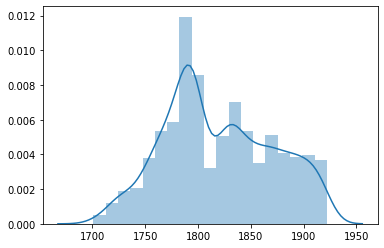

In [5]:
_ = sns.distplot(years)

There is a regular-looking increase in the number of volumes in the 18th century, which is explained by the fact that all these volumes were in the same subdirectory. Later periods are broken into numerous subdirectories corresponding to smaller and smaller ranges of time due to the increasing availability of data.

Let's see how many words occur how many times throughout the corpus.

In [6]:
all_words = pd.concat(docs).groupby('word').size().sort_values(ascending=False)
print('Number of words in loaded corpus:', len(all_words))

Number of words in loaded corpus: 1869228


Since this is quite a lot, we'll limit the vocabulary. We had reasonable results with the yearly aggregates, which had a vocabulary of size 10000, so we'll use the same vocabulary size here, keeping only the words that occur most frequently in the corpus.

In [7]:
vocab_size = 10_000
vocab = all_words.sort_values(ascending=False).head(vocab_size)
docs_cropped = [doc[doc['word'].isin(vocab.index)] for doc in docs]

Next, we tokenize the words.

In [8]:
%%time
token2word = dict(enumerate(vocab.index))
word2token = { v: k for k, v in token2word.items() }

for doc in docs_cropped:
    doc['token'] = doc['word'].map(word2token)

CPU times: user 40 s, sys: 624 ms, total: 40.7 s
Wall time: 40.7 s


Finally, we construct a document-word count matrix.

In [9]:
X = np.empty((len(docs_cropped), vocab_size))

for i, doc in enumerate(docs_cropped):
    X[i] = doc.set_index('token').reindex(range(len(vocab)))['freq'].fillna(0)

When working with yearly aggregate data, we normalized each row so that word counts were scaled by the total number of words counted in a year. We should do the same here, normalizing word counts by the number of words in a document. However, we go further this time and also weigh each word by its inverse document frequency to give more weight to words that are less common. Based on our observations regarding Zipf's law and logarithmic scaling when were analysing the yearly aggregate data, we logarithmically scale text frequencies here by setting `sublinear_tf=True`.

In [15]:
transformer = TfidfTransformer(sublinear_tf=True)
X_tfidf = transformer.fit_transform(X)

Let's scale the data and try to fit a linear regression model.

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_tfidf.todense())
X_train, X_test, y_train, y_test = train_test_split(X_scaled, years, test_size=0.2)

reg = LinearRegression()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.919192383208383

## Can we do better?

We're still working with multicollinear data, for which ordinary least squares is typically unsuitable. There are various ways to overcome this problem.

**Regularization**

As with yearly aggregate data, we make use of lasso regularization.

In [17]:
lasso = LassoCV(n_alphas=10, cv=3, n_jobs=-1)
lasso.fit(X_train, y_train)
lasso.score(X_test, y_test)

0.9346936265020922

With lasso regularization, we see a small but noticeable improvement. It's worthwhile to diagnose the fit visually as well with a scatter plot of true values against predicted values.

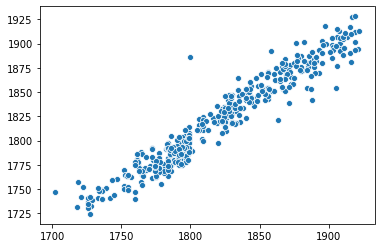

In [18]:
y_predict = lasso.predict(X_test)
_ = sns.scatterplot(y_test, y_predict)

A perfect model would arrange all the points on the line $y = x$. The above looks quite good but there's a single noticeable outlier that could be worthy of investigation.

Another good regression diagnostic is a plot of residuals against fitted values.

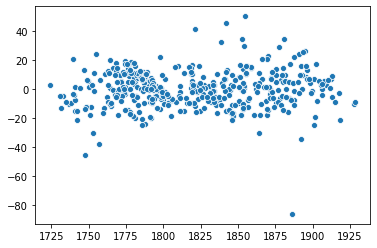

In [19]:
_ = sns.scatterplot(y_predict, y_test - y_predict)

It's a bit hard to tell, but the above plot almost appears to have a "double cone" shape, which would be indicative of some of [heteroscedasticity](https://en.wikipedia.org/wiki/Heteroscedasticity). This, too, could be worth looking into.

**Ensemble methods**

Let's try a different approach using random forests.

In [13]:
%%time
forest = RandomForestRegressor()
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

CPU times: user 13min 24s, sys: 899 ms, total: 13min 24s
Wall time: 13min 26s


0.9266993969481144

It's interesting to note how close the score of the random forest regressor is to that of the lasso regressor.

### Neural networks

Perhaps a linear model is simply unsuitable for the task at hand. But what kinds of non-linearities should we expect? The power of neural networks is their ability to automatically adapt to non-linearities. While neural networks are often associated with classification tasks, for which they've proven to be extraordinarily effective, they're equally suitable for regression. It's worth trying out a simple feedforward neural network architecture to determine just how far we can get with the available data.

To better compare with the performance of the more traditional regression models used above, we'll make use of the following Keras-adapted implementation of the $R^2$ coefficient of determination from [Recurrent Training](https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras).

In [5]:
def R2(y_true, y_pred):
    sum_squares = K.sum(K.square(y_true - K.mean(y_true)))
    sum_squares_resids =  K.sum(K.square(y_true-y_pred))
    
    return 1 - sum_squares_resids / (sum_squares + K.epsilon())

Perhaps the simplest non-trivial architecture we can use has a single hidden layer preceding. We'll also make use of dropout regularization. This leaves us with essentially two hyperparameters: the number of hidden units and the activation function. For simplicity, we'll stick with ReLU activations and use a pre-determined range of hidden layer sizes. We'll also use early stopping to avoid overfitting.

In [92]:
def build_model(hidden_units):
    model = Sequential()
    model.add(Dense(hidden_units, activation='relu', input_dim=10_000))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=[R2])
    return model

Neural networks are very sensitive to scaling, so we additionally scale the target variable now.

In [ ]:
y_scaled = StandardScaler().fit_transform(np.array(years).reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2)

Let's see what kind of performance we can get.

In [97]:
%%time
models = []
for hidden_units in [100, 500, 1000, 2000]:
    model = build_model(hidden_units)
    model.fit(X_train, y_train, epochs=20, verbose=0)
    score = model.evaluate(X_test, y_test)
    print(f'R^2 ({hidden_units} hidden units):', score[1])
    models.append(model)

422/422 [==============================] - 2s 4ms/step
R^2 (100 hidden units): 0.8867731633909506
422/422 [==============================] - 1s 3ms/step
R^2 (500 hidden units): 0.8965709192492951
422/422 [==============================] - 1s 3ms/step
R^2 (1000 hidden units): 0.8900056246897621
422/422 [==============================] - 2s 6ms/step
R^2 (2000 hidden units): 0.8808171121995031
CPU times: user 17min 16s, sys: 16.7 s, total: 17min 33s
Wall time: 11min 4s


## Why can't we do better?

Although we've tested a variety of rather different models, they all seem to reach an $R^2$ value of around 0.9. This in itself is quite informative and suggests that this simply may be the best we can do with what we have. In other words, it may be the case that the models we've built come close to the [Bayes estimator](https://en.wikipedia.org/wiki/Bayes_estimator) for the mean squared error. The reasons for this as well as possible ways to overcome this limitation seem to fall into three categories.

**Amount of data**

We may simply need to increase the amount of data we're working with. So far, we've already limited the data we're using from the HTRC data set in two ways: by limiting the number of volumes per century and by limiting the number of words tokenized. Note that the first limitation reduces the number of training examples and the second the number of features. It would most likely be easier and more fruitful to begin by increasing the number of training examples.

The main difficulty with increasing the amount of utilized data, of course, is computational power. Working with larger data sets shifts the nature of the problem at hand from data analysis and model building to problems in optimization and cloud computing.

**Nature of data**

The fact that linear models appear to be essentially optimal for this data suggests that the only relationships between the target and the features are in fact linear. For the most part, this is quite believable: most words will either be used a constant amount over a period of time or their use will steadily increase or decrease. Even if these trends are not entirely linear, it's hard to image that they would be wildly non-linear; therefore, linear models should be able to provide a good approximation to the truth. 

**Type of data**

Our ultimate goal is to predict the date of a publication from the *raw textual content*. So far, we have only used preprocessed bag-of-words data. Leaving aside the effects that different preprocessing schemes may have, the fact that we only know word counts means we're losing all the syntactic and semantic information in the original data source.

Working with raw text could potentially allow for much more predictive power. However, it would open the doors to a wide variety of increasingly complex modeling strategies for natural language processing; some that come to mind are word embeddings, convolutional neural networks, and recurrent neural networks. An investigation into these strategies would likely be significantly more complex than what we have done so far. It's certainly worth asking whether or not this would be worth it, given the performance we've obtained with rather simple models.

## From preprocessing to prediction

Although we've built several models with reasonable predictive power, the fact that we used preprocessed training data means we can't apply these directly to the data of interest, which would be raw text. We need to add a preliminary preprocessing and tokenization step to our data pipeline.

### Reverse engineering the tokenizer

The [documentation](https://wiki.htrc.illinois.edu/display/COM/Word+Frequencies+in+English-Language+Literature) for the data set mentions that the [OpenNLP](http://opennlp.apache.org/) tokenizer was used. However, OpenNLP contains several tokenization methods and an attempt to use the `SimpleTokenizer` revealed that the resulting tokens were quite different than those appearing in the data set.

Much better (though not perfect) results were obtained using the default tokenizer from the natural language processing package [SpaCy](https://spacy.io/).

In [101]:
nlp = spacy.lang.en.English()
tokenizer = nlp.Defaults.create_tokenizer(nlp)

We can check the difference between the tokens produced by this tokenizer and the ones used in the HTRC dataset by *detokenizing* a bag-of-words vector from the data set and *retokenizing* it with the SpaCy tokenizer. The following function defines the detokenizer.

In [104]:
def vector2text(x):
    return ' '.join([(token2word[t] + ' ') * int(n) for t, n in enumerate(x)])

Detokenized text will be retokenized and counted using a vectorizer built from the restricted HTRC vocabulary and the SpaCy tokenizer; the latter must be converted to an ordinary function for compatibility with scikit-learn.

In [117]:
# convert the SpaCy tokenizer to an ordinary function
def tok(string):
    return [str(t) for t in tokenizer(string)]

# build a vectorizer from the HTRC vocabulary using the SpaCy tokenizer
cv = CountVectorizer(vocabulary=word2token, tokenizer=tok)

We'll measure the closeness of the two tokenizers by the absolute different between the original bag-of-words vector and the detokenized-retokenized vector, normalized by the average number of tokens counted by the two tokenizers.

In [154]:
def ratio_different_tokens(index):
    x = cv.transform([vector2text(X[index, :])]).reshape(-1, 1)
    avg_num_tokens = (x.sum() + X[index, :].sum()) / 2
    different_tokens = np.abs(x - X[index, :].reshape(-1, 1)).sum()
    return different_tokens / avg_num_tokens

We see below that that the difference between our tokenizer and the one used to create the HTRC data set is less than 2%.

In [155]:
np.nanmean([ratio_different_tokens(i) for i in range(X.shape[0])])

0.016181602076455307

### A simple data pipeline

Let's build a simple pipeline using the various data transformations we've used above, together with the trained lasso regressor for prediction. We'll also need a couple of utility transformers.

In [183]:
tolist = FunctionTransformer(lambda x: [x])
todense = FunctionTransformer(lambda x: x.todense())

pipe = Pipeline([('tolist', tolist),
                 ('count', cv),
                 ('tfidf', transformer),
                 ('densify', todense),
                 ('scale', scaler),
                 ('predict', lasso)])

A visualization of this rather simple pipeline is given below.

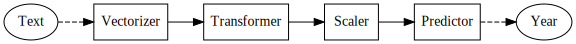

In [13]:
with open('pipeline.dot', 'r') as f:
    diagram = f.read()
graphviz.Source(diagram)

We'll test this out on the first chapter of Moby Dick; the original publication date is 1851.

In [184]:
with open('doc2date/static/moby-dick.txt', 'r') as f:
    text = f.read()

int(pipe.predict(text)[0])

1847

In order to deploy our model, we'd like to export this pipeline, say via pickling. However, certain components (the function transformers and the count vectorizer, which is built from a function), aren't picklable. This isn't an issue: We can pickle the essential components and re-construct this pipeline in the app we will deploy.

In [186]:
for name, comp in [('tokenizer', tokenizer),
                   ('word2token', word2token),
                   ('transformer', transformer),
                   ('scaler', scaler),
                   ('predictor', lasso)]:
    with open('../doc2date/pickle/' + name + '.pickle', 'wb') as f:
        pickle.dump(comp, f, protocol=pickle.HIGHEST_PROTOCOL)

## Continue reading

[Part 3](doc2date-03.ipynb)